In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, sweep_poly
from librosa import cqt,stft, note_to_hz
from librosa.feature import melspectrogram
import sys
sys.path.insert(0,'../')
from scipy.io import wavfile

import Spectrogram
import torch
import torch.nn as nn

In [2]:
cmap = 'jet'
fmin = note_to_hz("E1") # for CQT use

fs = 44100
t = 1
f0 = 55
f1 = 22050

# parameters for CQT
bins_per_octave = 24
n_bins = int(bins_per_octave*7.5)

epsilon = 1e-5 # for taking log

# Getting a chromatic scale audio

In [3]:
x = wavfile.read('./chromatic_scale.wav') # it returns as (sampling rate, audio)
x = x[1].mean(1) # getting audio and convert stereo to mono
x = x[x!=0] # cut out slience from the audio
x = x[:int(9.2e5)] # remove excessive endings
x = x.astype(np.float32) # cast it to float so that it can be used with PyTorch

# Comparing CQT results

Low pass filter created, time used = 0.0020 seconds
No early downsampling is required, downsample_factor =  1
Early downsampling filter created, time used = 0.0001 seconds
CQT kernels created, time used = 0.0052 seconds
STFT kernels created, time used = 0.0444 seconds


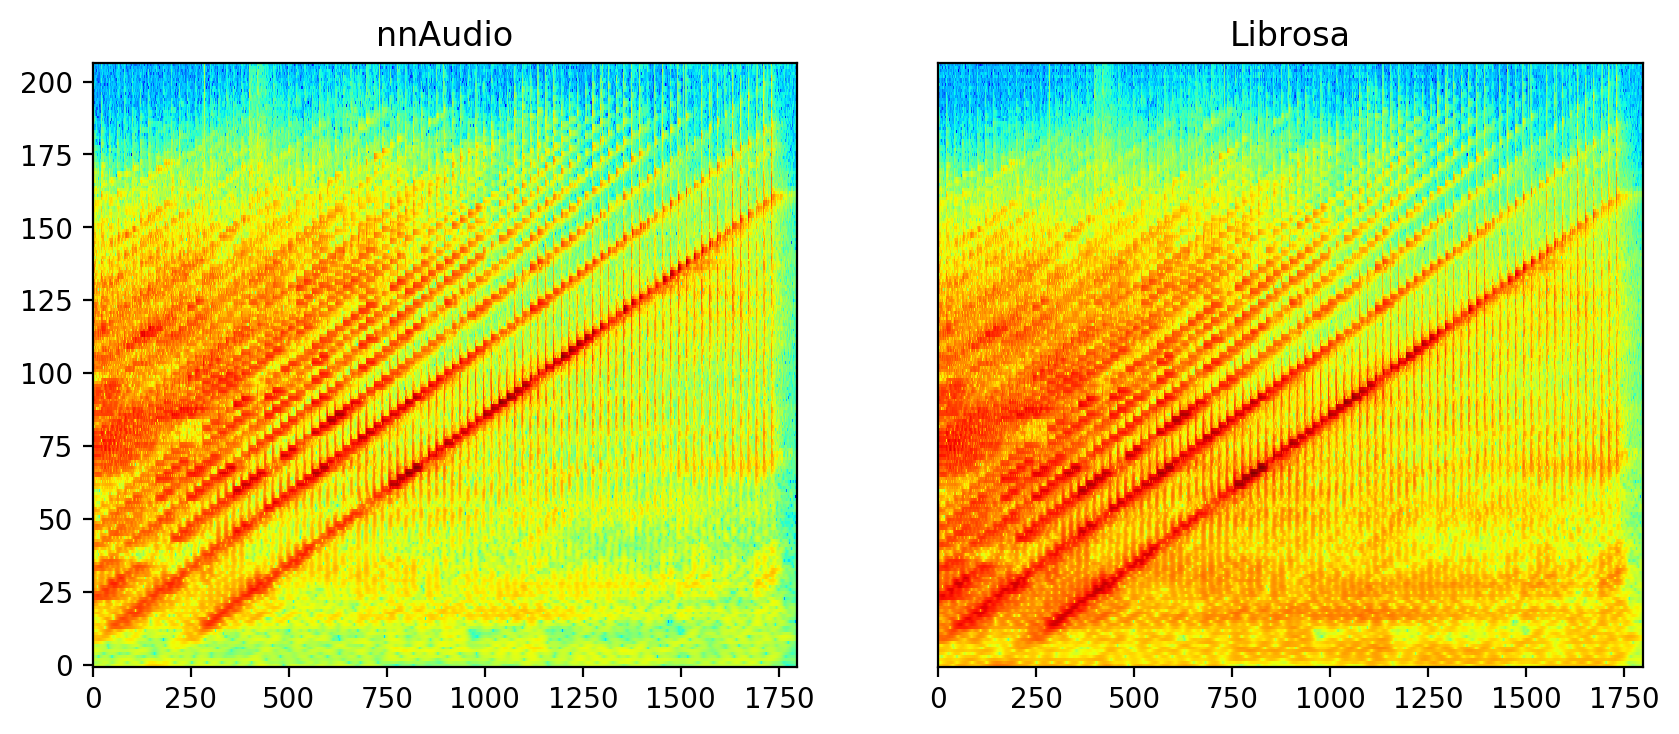

In [4]:
r=2
bins_per_octave = 12*r
n_bins = 104*r-1
CQT2010_layer = Spectrogram.CQT2010(fs, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, pad_mode='constant')

cqt_x = CQT2010_layer(torch.tensor(x[None, None, :]))
output_lib = cqt(x, sr=fs, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, pad_mode='constant')

fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,4))
ax[0].imshow(np.log(cqt_x[0]+epsilon), aspect='auto', origin='lower', cmap=cmap)
ax[1].imshow(np.log(abs(output_lib)+epsilon), aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
ax[0].title.set_text("nnAudio")
ax[1].title.set_text("Librosa")

# Melspectrogram

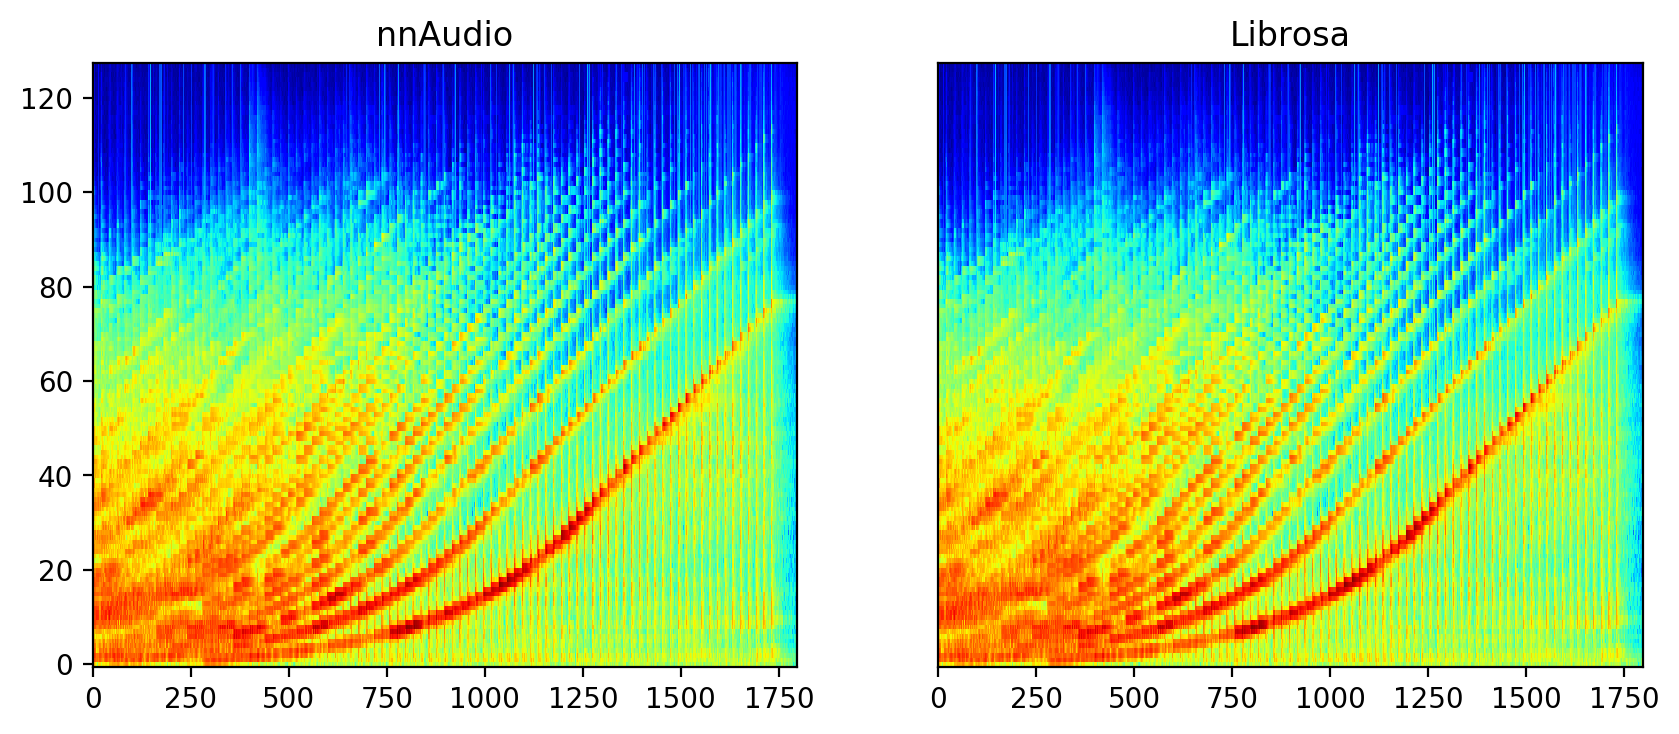

In [5]:
mel_layer = Spectrogram.MelSpectrogram(fs)
mel_x= mel_layer(torch.tensor(x[None, None, :]))
output_lib = melspectrogram(x, fs)

fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,4))
ax[0].imshow(np.log(mel_x[0]+epsilon), aspect='auto', origin='lower', cmap=cmap)
ax[1].imshow(np.log(abs(output_lib+epsilon)), aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
ax[0].title.set_text("nnAudio")
ax[1].title.set_text("Librosa")

In [6]:
print("Linear sweep all close ", np.allclose(mel_x[0].numpy(), output_lib, rtol=1e-3, atol=1e-4))

Linear sweep all close  True


# STFT linear freq

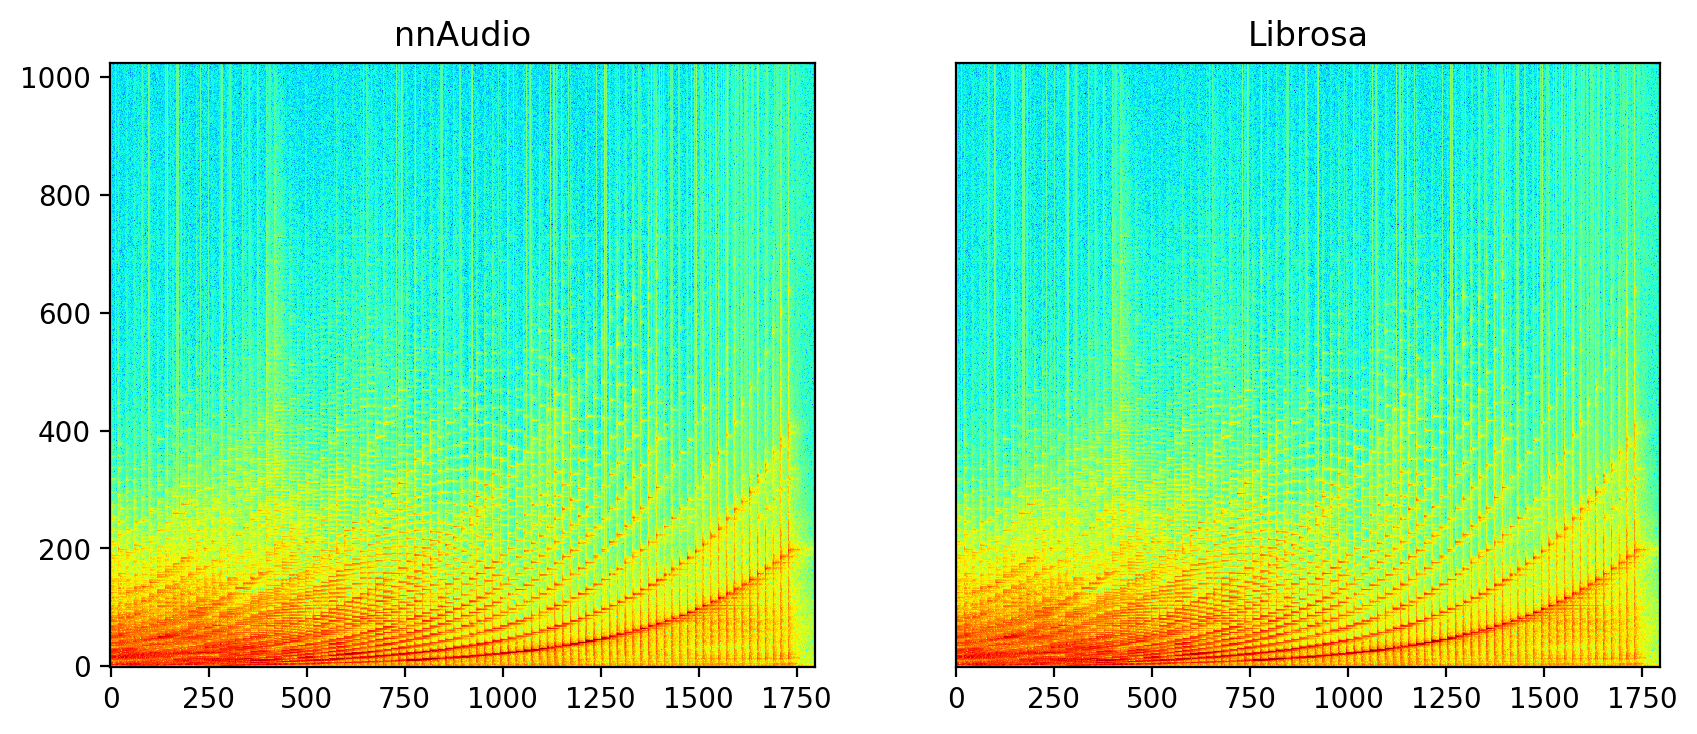

In [7]:
stft_layer_no = Spectrogram.STFT()
stft_x = stft_layer_no(torch.tensor(x[None, None, :]))
output_lib = abs(stft(x))

fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,4))
ax[0].imshow(np.log(stft_x[0]+epsilon), aspect='auto', origin='lower', cmap=cmap)
ax[1].imshow(np.log(abs(output_lib)), aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
ax[0].title.set_text("nnAudio")
ax[1].title.set_text("Librosa")

In [8]:
print("Linear sweep all close ", np.allclose(stft_x[0].numpy(), output_lib, rtol=1e-2, atol=1e-2))

Linear sweep all close  True


# STFT log-freq

sampling rate = 44100. Please make sure the sampling rate is correct in order to get a valid freq range


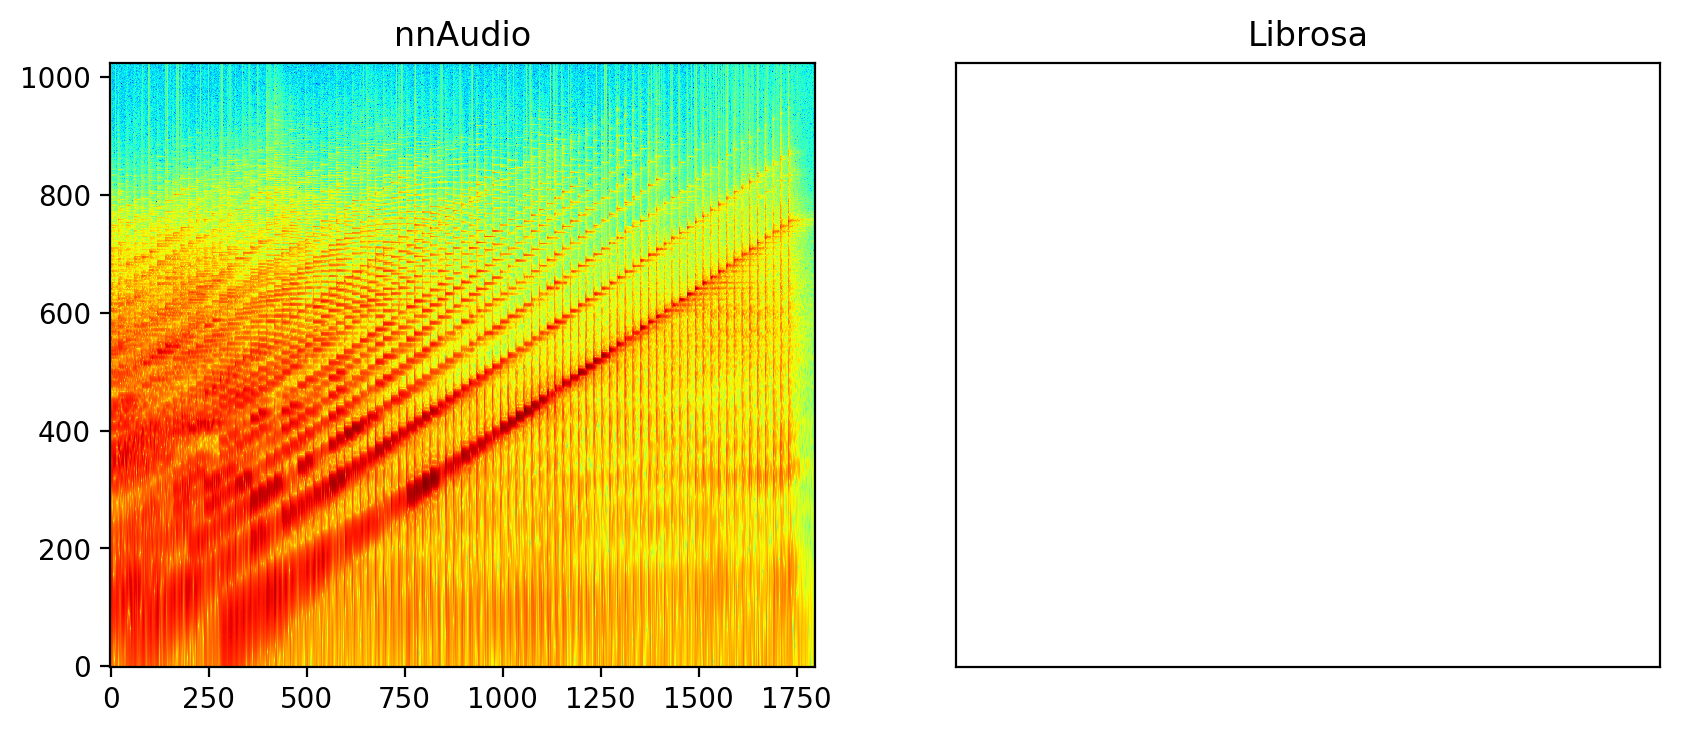

In [9]:
stft_layer = Spectrogram.STFT(freq_scale='log', fmin=fmin, fmax=22050, sr=44100)
stft_log_x = stft_layer(torch.tensor(x[None, None, :]))

fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,4))
ax[0].imshow(np.log(stft_log_x[0]+epsilon), aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[0].title.set_text("nnAudio")
ax[1].title.set_text("Librosa")